In [ ]:
# Main dependencies that are not native to Colab
!pip install nilearn
!pip install scikit-posthocs
!pip install xgboost
!pip -q install SimpleITK


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.7/12.7 MB 56.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.6/52.6 MB 16.4 MB/s eta 0:00:00


In [ ]:
# ===========================================
# The dataset (file with .tar extension) can be obtained
# from the link: https://nitrc.org/frs/downloadlink.php/3814
# ===========================================
# The .tsv file containing the labels for each patient
# can be obtained from the link:
# https://nitrc.org/frs/download.php/9024/adhd200_preprocessed_phenotypics.tsv
# ===========================================

from google.colab import drive
drive.mount('/content/drive')

import os, glob, subprocess, shlex

TARGET_DIR = "/content/drive/MyDrive/RHARA_TCC" # Define the drive path
ARCHIVE    = "test_peking.tar"

# 1) Go to the correct folder
os.makedirs(TARGET_DIR, exist_ok=True)
os.chdir(TARGET_DIR)
print("Working dir:", os.getcwd())

# 2) Check if the file is really here
print("\nFolder archives:")
for p in glob.glob("*"):
    print(" -", p)

# 3) Full path to the file
archive_path = os.path.join(TARGET_DIR, ARCHIVE)
print("\nTarget archive:", archive_path, "exists?", os.path.exists(archive_path))

# 4) List tar contents before extracting (sanity check)
if os.path.exists(archive_path):
    print("\nFirst items inside the package:")
    cmd_list = f"tar -tf {shlex.quote(archive_path)} | head -n 20"
    subprocess.run(cmd_list, shell=True, check=False)

    # 5) Extract (use -xvf for .tar; -xzvf for .tar.gz; -xjvf for .tar.bz2)
    print("\nExtracting...")
    if ARCHIVE.endswith(".tar.gz") or ARCHIVE.endswith(".tgz"):
        cmd_extract = f"tar -xzvf {shlex.quote(archive_path)} -C {shlex.quote(TARGET_DIR)}"
    elif ARCHIVE.endswith(".tar.bz2"):
        cmd_extract = f"tar -xjvf {shlex.quote(archive_path)} -C {shlex.quote(TARGET_DIR)}"
    elif ARCHIVE.endswith(".tar"):
        cmd_extract = f"tar -xvf {shlex.quote(archive_path)} -C {shlex.quote(TARGET_DIR)}"
    else:
        raise ValueError("Extension not allowed. Please, inform .tar, .tar.gz/.tgz or .tar.bz2")

    subprocess.run(cmd_extract, shell=True, check=True)

    print("\nDone! Content extracted, now the items are in the folder:")
    for p in glob.glob("*"):
        print(" -", p)
else:
    print("\n There is no file in", TARGET_DIR,
          "\n Verify the drive path set at the beginning."
          "\n If it is in another place, you should move it to drive path of TARGET_DIR/ARCHIVE.")


In [ ]:
# === Connectomes ready for ML:
# FD per TR (Time of Repetition),
# scrubbing and CSV export ===

import re, os, sys, json, gzip, shutil, warnings, tempfile, subprocess
from pathlib import Path
import numpy as np
import pandas as pd

from nilearn import datasets
from nilearn.maskers import NiftiLabelsMasker
from nilearn.image import load_img, mean_img, index_img
from nilearn.masking import compute_epi_mask

# =============================================================================
# CONFIG
# =============================================================================
BASE_DIR  = Path("/content/drive/MyDrive/RHARA_TCC/peking_test_output_nifty").resolve()
FMRI_DIR  = BASE_DIR / "fmri"
INTER_DIR = BASE_DIR / "intermediate"
OUT_DIR   = Path("/content/drive/MyDrive/RHARA_TCC/features").resolve()
OUT_DIR.mkdir(parents=True, exist_ok=True)

# Extraction parameters
STANDARDIZE = "zscore_sample"   # z-score over time for each ROI
DETREND     = True
SMOOTH_FWHM = None

# Scrubbing parameters
DO_SCRUB       = True
FD_THRESH      = 0.20            # mm
MIN_TR_AFTER   = 100             # minimum number of volumes after scrubbing to accept the subject
HEAD_RADIUS_MM = 50.0

print("BASE_DIR =", BASE_DIR)
print("OUT_DIR  =", OUT_DIR)
print("Scrubbing:", DO_SCRUB, "| FD_THRESH:", FD_THRESH, "| MIN_TR_AFTER:", MIN_TR_AFTER)

# =============================================================================
# UTIL: robust motion reading (3–6 columns; fallback ASCII; gz; etc.)
# =============================================================================
def load_motion_params_auto(mpath):
    import scipy.io as sio
    p = Path(mpath)
    if not p.exists():
        raise FileNotFoundError(p)

    def _is_gz(path: Path) -> bool:
        with open(path, "rb") as f:
            return f.read(2) == b"\x1f\x8b"

    def _read_bytes(path: Path) -> bytes:
        if _is_gz(path):
            with gzip.open(path, "rb") as gz:
                return gz.read()
        with open(path, "rb") as f:
            return f.read()

    def _normalize_matrix(M, src_hint=""):
        M = np.asarray(M)
        if M.ndim != 2:
            raise ValueError(f"Expected 2D, and it was {M.ndim}D")
        if M.shape[0] in (6, 7) and M.shape[1] > M.shape[0]:
            M = M.T
        if M.shape[1] > 6:
            M = M[:, :6]
        if M.shape[1] < 3:
            raise ValueError(f"Not enough columns: {M.shape}")
        if M.shape[1] < 6:
            n_missing = 6 - M.shape[1]
            M = np.hstack([M, np.zeros((M.shape[0], n_missing), dtype=float)])
            print(f"[motion] Warning: '{src_hint}' with {6-n_missing} col.; completing {n_missing} with zeros.")
        return M.astype(float)

    def _pick(cands, src_hint=""):
        if not cands:
            raise ValueError("No appropriate 2D matrix was found.")
        M = max(cands, key=lambda a: a.shape[0])
        return _normalize_matrix(M, src_hint)

    raw = _read_bytes(p)

    # 1) MAT v5/v7
    try:
        with tempfile.NamedTemporaryFile(suffix=".mat", delete=True) as tmp:
            tmp.write(raw); tmp.flush()
            d = sio.loadmat(tmp.name, squeeze_me=True, struct_as_record=False)
        cands = []
        for k, v in d.items():
            if k.startswith("__"): continue
            a = np.asarray(v)
            if a.ndim == 2 and a.size > 0:
                cands.append(a)
        return _pick(cands, f"{p.name} (MAT v5/v7)")
    except Exception as e_scipy:
        # 2) v7.3/HDF5
        try:
            import h5py
            with tempfile.NamedTemporaryFile(suffix=".mat", delete=True) as tmp:
                tmp.write(raw); tmp.flush()
                with h5py.File(tmp.name, "r") as f:
                    cands = []
                    def walk(g):
                        for _, v in g.items():
                            if isinstance(v, h5py.Dataset):
                                a = np.asarray(v[()])
                                if a.ndim == 2 and a.size > 0:
                                    cands.append(a)
                            elif isinstance(v, h5py.Group):
                                walk(v)
                    walk(f)
            return _pick(cands, f"{p.name} (MAT v7.3)")
        except Exception as e_h5:
            # 3) Tolerate ASCII
            try:
                text = raw.decode("utf-8", errors="ignore")
                rows = []
                for line in text.splitlines():
                    line = line.strip()
                    if not line or line.startswith(("#","%","//","@")): continue
                    tokens = [t for t in re.split(r"[,\t ;]+", line) if t]
                    nums = []
                    for t in tokens:
                        try:
                            if re.fullmatch(r"[-+]?(\d+(\.\d*)?|\.\d+)([eE][-+]?\d+)?", t):
                                nums.append(float(t))
                        except: pass
                    if nums: rows.append(nums)
                if not rows:
                    raise ValueError("ASCII without numerical lines")
                maxc = max(len(r) for r in rows)
                A = np.array([r + [np.nan]*(maxc-len(r)) for r in rows], dtype=float)
                A = A[np.any(np.isfinite(A), axis=1)]
                keep = np.any(np.isfinite(A), axis=0)
                A = A[:, keep]
                if A.size == 0 or A.shape[1] < 3:
                    raise ValueError(f"ASCII with {A.shape[1] if A.ndim==2 else 0} columns")
                return _normalize_matrix(A, f"{p.name} (ASCII)")
            except Exception as e_txt:
                raise ValueError(
                    f"Failed during the file reading '{p.name}': "
                    f"sio.loadmat -> {type(e_scipy).__name__}: {e_scipy}; "
                    f"h5py -> {type(e_h5).__name__}: {e_h5}; "
                    f"ASCII -> {type(e_txt).__name__}: {e_txt}"
                )

def compute_fd_tr(M, head_radius_mm=50.0):
    """ FD per TR (Power). M: [Tx Ty Tz Rx Ry Rz], rotations assumed in rad if already large; otherwise convert. """
    M = np.asarray(M, float)
    rot = M[:, 3:6].astype(float)
    trans = M[:, 0:3].astype(float)
    # auto-detecção de graus
    if np.nanmax(np.abs(rot)) > 3.2:  # ~183°
        rot = np.deg2rad(rot)
    rot_mm = rot * head_radius_mm
    mm = np.hstack([trans, rot_mm])
    diff = np.vstack([np.zeros((1,6)), np.abs(np.diff(mm, axis=0))])
    fd = diff.sum(axis=1)
    return fd

# =============================================================================
# Fallback: estimate 6DOF motion from NIfTI with SimpleITK
# =============================================================================
def _sitk_available():
    try:
        import SimpleITK as sitk  # noqa
        return True
    except Exception:
        return False

def estimate_motion_with_sitk(nifti_4d_path, out_txt=None, downsample_mm=4.0, max_iter=50):
    """Returns (T,6): Tx Ty Tz Rx Ry Rz, rotations in RAD. Saves to out_txt if desired."""
    import SimpleITK as sitk
    img4d = sitk.ReadImage(str(nifti_4d_path))
    size = img4d.GetSize()
    if len(size) != 4:
        raise ValueError("NIfTI 4D format was expected.")
    T = size[3]
    # reference volume
    ref = sitk.Extract(img4d, size[0:3]+(0,), (0,0,0,0))
    # downsample
    def _down(img):
        sp = np.array(list(img.GetSpacing()))
        new_sp = np.array([downsample_mm, downsample_mm, downsample_mm])
        factor = sp / new_sp
        new_size = np.maximum(np.round(np.array(img.GetSize())*factor).astype(int), 8)
        return sitk.Resample(img, tuple(map(int, new_size)), sitk.Transform(),
                             sitk.sitkLinear, img.GetOrigin(), tuple(new_sp),
                             img.GetDirection(), 0.0, img.GetPixelID())
    ref_ds = _down(ref)

    reg = sitk.ImageRegistrationMethod()
    reg.SetMetricAsMattesMutualInformation(32)
    reg.SetMetricSamplingStrategy(reg.RANDOM)
    reg.SetMetricSamplingPercentage(0.2, 123)
    reg.SetInterpolator(sitk.sitkLinear)
    reg.SetOptimizerAsRegularStepGradientDescent(1.0, .001, max_iter, relaxationFactor=0.5)
    reg.SetOptimizerScalesFromPhysicalShift()
    reg.SetShrinkFactorsPerLevel([4,2,1])
    reg.SetSmoothingSigmasPerLevel([2,1,0])
    reg.SmoothingSigmasAreSpecifiedInPhysicalUnitsOn()

    R = []
    for t in range(T):
        mov = sitk.Extract(img4d, size[0:3]+(0,), (0,0,0,t))
        mov_ds = _down(mov)
        init = sitk.CenteredTransformInitializer(
            ref_ds, mov_ds, sitk.Euler3DTransform(), sitk.CenteredTransformInitializerFilter.GEOMETRY
        )
        reg.SetInitialTransform(init, inPlace=False)
        final = reg.Execute(ref_ds, mov_ds)
        # Euler3D: parameters = (Rx,Ry,Rz, Tx,Ty,Tz)  (rotations in RAD, translations in mm)
        rx, ry, rz, tx_mm, ty_mm, tz_mm = final.GetParameters()
        R.append([tx_mm, ty_mm, tz_mm, rx, ry, rz])
    R = np.array(R, dtype=float)
    if out_txt:
        np.savetxt(out_txt, R, fmt="%.6f")
    return R

def is_motion_degenerate(M, n_timepoints_expected=None):
    M = np.asarray(M)
    if M.ndim != 2 or M.shape[1] < 6:
        return True
    uniq = [len(np.unique(M[:,i])) for i in range(6)]
    # se muitas colunas “paradas”, é suspeito
    deg_cols = sum(u <= 2 for u in uniq)
    if deg_cols >= 4:
        return True
    if n_timepoints_expected is not None and abs(M.shape[0] - n_timepoints_expected) > 5:
        return True
    return False

# =============================================================================
# Discover subjects and candidate motion files
# =============================================================================
def _parse_sid_from_fname(fname: str) -> str:
    pats = [
        r"^func_(.+?)_session_1_run1_nativefunc\.nii(\.gz)?$",
        r"^func_(.+?)_session_1_run1_native\.nii(\.gz)?$",
        r"^func_(.+?)_session_1_run1_.*\.nii(\.gz)?$",
        r"^fmri_(.+?)_session_1_run1\.nii(\.gz)?$",
        r"^fmri_(.+?)_session_1_run1_.*\.nii(\.gz)?$",
    ]
    for pat in pats:
        m = re.match(pat, fname)
        if m: return m.group(1)
    if fname.startswith("func_") and "_session" in fname:  return fname.split("func_")[1].split("_session")[0]
    if fname.startswith("fmri_") and "_session" in fname:  return fname.split("fmri_")[1].split("_session")[0]
    raise ValueError(f"It was unable to extract SID: {fname}")

def _first_existing(*paths):
    flat = []
    for p in paths:
        if p is None: continue
        if isinstance(p, (list, tuple, set)): flat.extend(p)
        else: flat.append(p)
    for p in flat:
        try:
            if Path(p).exists():
                return Path(p)
        except TypeError:
            continue
    return None

def discover_subjects():
    fmri_patterns = [
        "func_*_session_1_run1*.nii.gz","func_*_session_1_run1*.nii",
        "fmri_*_session_1_run1*.nii.gz","fmri_*_session_1_run1*.nii",
    ]
    fmri_files = []
    for pat in fmri_patterns:
        fmri_files.extend(sorted(FMRI_DIR.glob(pat)))
    seen = set()
    fmri_files = [p for p in fmri_files if not (p in seen or seen.add(p))]
    rows = []
    for fmri_path in fmri_files:
        sid = _parse_sid_from_fname(fmri_path.name)
        mc_dir = INTER_DIR / sid / "motion_correction"
        motion_candidates = [
            mc_dir / f"motion_parameters_{sid}_session_1_run1.mat",
            mc_dir / f"{sid}_session_1_run1_motion_parameters.mat",
            mc_dir / f"rp_{sid}_session_1_run1.txt", mc_dir / f"rp_{sid}_session_1_run1.txt.gz",
            mc_dir / f"{sid}_session_1_run1.par",  mc_dir / f"{sid}_session_1_run1.par.gz",
            mc_dir / f"{sid}_session_1_run1.1D",   mc_dir / f"{sid}_session_1_run1.1D.gz",
            mc_dir / f"{sid}_session_1_run1.tsv",  mc_dir / f"{sid}_session_1_run1.tsv.gz",
            mc_dir / f"{sid}_session_1_run1.csv",  mc_dir / f"{sid}_session_1_run1.csv.gz",
            *(sorted(mc_dir.glob("*.mat*")) if mc_dir.exists() else []),
            *(sorted(mc_dir.glob("*.txt*")) if mc_dir.exists() else []),
            *(sorted(mc_dir.glob("*.par*")) if mc_dir.exists() else []),
            *(sorted(mc_dir.glob("*.1D*"))  if mc_dir.exists() else []),
            *(sorted(mc_dir.glob("*.tsv*")) if mc_dir.exists() else []),
            *(sorted(mc_dir.glob("*.csv*")) if mc_dir.exists() else []),
        ]
        motion_path = _first_existing(*motion_candidates)
        rows.append({"subject_id": sid, "fmri": fmri_path.as_posix(),
                    "motion": motion_path.as_posix() if motion_path else None})
    df = pd.DataFrame(rows)
    print(f"[discover_subjects] Sujeitos listados: {len(df)}")
    if not df.empty:
        print(df.head(5).to_string(index=False))
    return df

# =============================================================================
# Extraction by atlas + scrubbing + export
# =============================================================================
def fisher_z(C):
    C = np.clip(C, -0.999999, 0.999999)
    return np.arctanh(C)

def upper_tri_vector(C):
    iu = np.triu_indices(C.shape[0], k=1)
    return C[iu]

def subject_connectivity(fmri_path, motion_path, atlas_img, atlas_labels, sid, atlas_name):
    # 1) motion → FD per TR (with fallback)
    img = load_img(fmri_path)
    T = img.shape[-1]

    if motion_path:
        try:
            M = load_motion_params_auto(motion_path)
            if is_motion_degenerate(M, n_timepoints_expected=T):
                raise ValueError("movimento degenerado")
            motion_src = "provided"
        except Exception:
            M = None
    else:
        M = None

    if M is None or is_motion_degenerate(M, n_timepoints_expected=T):
        if not _sitk_available():
            raise RuntimeError("SimpleITK is not installed. Please, run: !pip install SimpleITK")
        out_txt = INTER_DIR / sid / "motion_correction" / f"realign_sitk_{sid}.txt"
        out_txt.parent.mkdir(parents=True, exist_ok=True)
        print(f"[{sid}] SimpleITK fallback…")
        M = estimate_motion_with_sitk(fmri_path, out_txt=out_txt.as_posix(), downsample_mm=4.0, max_iter=50)
        motion_src = "sitk"

    fd_tr = compute_fd_tr(M, head_radius_mm=HEAD_RADIUS_MM)

    # 2) scrubbing
    keep_idx = np.arange(T)
    if DO_SCRUB:
        keep_mask = fd_tr <= FD_THRESH
        keep_idx  = np.where(keep_mask)[0]
        if keep_idx.size < MIN_TR_AFTER:
            raise ValueError(f"{sid}: After scrubbing: {keep_idx.size} TRs (<{MIN_TR_AFTER}).")

    # 3) signals and correlation (post-scrubbing)
    if DO_SCRUB:
        fmri_proc = index_img(img, keep_idx)
    else:
        fmri_proc = img

    # automatic EPI mask for the subject (stable and fast)
    mean_epi = mean_img(fmri_proc)
    mask_img = compute_epi_mask(mean_epi)

    masker = NiftiLabelsMasker(
        labels_img=atlas_img, mask_img=mask_img,
        resampling_target="labels", interpolation="nearest",
        standardize=STANDARDIZE, detrend=DETREND, smoothing_fwhm=SMOOTH_FWHM,
        strategy="mean", verbose=0
    )
    signals = masker.fit_transform(fmri_proc)  # (Tscrub, n_rois)
    signals = np.nan_to_num(signals, copy=False)

    # protections and connectivity
    var_ok = signals.var(axis=0) > 1e-12
    if var_ok.sum() < 2:
        raise ValueError(f"{sid}: Time Series variance is too low.")
    C = np.corrcoef(signals[:, var_ok].T)
    Z = fisher_z(C)
    vec = upper_tri_vector(Z)

    # 4) metadata + auxiliary saves (FD per TR and kept indices)
    subj_dir = OUT_DIR / atlas_name / sid
    subj_dir.mkdir(parents=True, exist_ok=True)
    np.save(subj_dir / f"{sid}_fd_tr.npy", fd_tr)
    if DO_SCRUB:
        np.save(subj_dir / f"{sid}_kept_idx.npy", keep_idx)

    meta = {
        "subject_id": sid,
        "atlas": atlas_name,
        "n_timepoints_raw": int(T),
        "n_timepoints_kept": int(signals.shape[0]),
        "n_rois_total": int(len(atlas_labels)),
        "n_rois_used": int(var_ok.sum()),
        "fd_mean_raw": float(fd_tr.mean()),
        "fd_median_raw": float(np.median(fd_tr)),
        "fd_pct_gt_0p2_raw": float((fd_tr > 0.2).mean()*100.0),
        "motion_source": motion_src,
        "standardize": STANDARDIZE,
        "detrend": DETREND,
        "scrubbing": DO_SCRUB,
        "fd_thresh": FD_THRESH
    }
    with open(subj_dir / f"{sid}_meta.json", "w") as f:
        json.dump(meta, f, indent=2)

    return vec, meta

def build_and_export_connectomes():
    warnings.filterwarnings("ignore", category=FutureWarning)

    df = discover_subjects()
    if df.empty:
        print("No fMRI was found."); return

    # Load atlases
    print("\n[atlas] AAL (SPM12)…")
    aal = datasets.fetch_atlas_aal(version="SPM12")
    atlas_img_aal = load_img(aal.maps)
    labels_aal = list(aal.labels)

    print("[atlas] Schaefer200 (Yeo7, 2mm)…")
    sch = datasets.fetch_atlas_schaefer_2018(n_rois=200, yeo_networks=7, resolution_mm=2)
    atlas_img_sch = load_img(sch.maps)
    labels_sch = list(sch.labels)

    # Structures to build CSVs
    rows_aal, rows_sch = [], []
    fd_rows = []

    # Subject loop (single pass) — computes and exports everything
    for _, r in df.iterrows():
        sid, fmri_path, motion_path = r["subject_id"], r["fmri"], r["motion"]
        try:
            # AAL
            vec_aal, meta_aal = subject_connectivity(fmri_path, motion_path, atlas_img_aal, labels_aal, sid, "aal")
            rows_aal.append([sid, *vec_aal])
            # Schaefer
            vec_sch, meta_sch = subject_connectivity(fmri_path, motion_path, atlas_img_sch, labels_sch, sid, "schaefer200")
            rows_sch.append([sid, *vec_sch])

            # FD summary (post-scrubbing reflected in n_timepoints_kept)
            fd_rows.append({
                "subject_id": sid,
                "fd_mean_raw": meta_aal["fd_mean_raw"],
                "fd_median_raw": meta_aal["fd_median_raw"],
                "fd_pct_gt_0p2_raw": meta_aal["fd_pct_gt_0p2_raw"],
                "n_timepoints_raw": meta_aal["n_timepoints_raw"],
                "n_timepoints_kept": meta_aal["n_timepoints_kept"],
                "motion_source": meta_aal["motion_source"],
            })

            print(f"[OK] {sid}: AAL {len(vec_aal)} edges | SCH {len(vec_sch)} edges | kept {meta_aal['n_timepoints_kept']}/{meta_aal['n_timepoints_raw']} TRs")
        except Exception as e:
            print(f"[SKIP] {sid}: {e}")

    # Build DataFrames
    def _mk_df(rows, name):
        if not rows:
            return pd.DataFrame()
        X = np.vstack([row[1:] for row in rows])
        cols = [f"{name}_edge_{i}" for i in range(X.shape[1])]
        dfmat = pd.DataFrame(X, columns=cols)
        dfmat.insert(0, "subject_id", [row[0] for row in rows])
        return dfmat

    df_aal = _mk_df(rows_aal, "aal")
    df_sch = _mk_df(rows_sch, "sch")
    fd_df  = pd.DataFrame(fd_rows)

    # Save individual CSVs per atlas
    aal_csv = OUT_DIR / "aal_connectomes.csv"
    sch_csv = OUT_DIR / "schaefer200_connectomes.csv"
    df_aal.to_csv(aal_csv, index=False)
    df_sch.to_csv(sch_csv, index=False)

    # Save combined (merge by subject_id)
    combined = df_aal.merge(df_sch, on="subject_id", how="inner")
    comb_csv = OUT_DIR / "combined_connectomes.csv"
    combined.to_csv(comb_csv, index=False)

    # Save FD summary
    fd_csv = OUT_DIR / "fd_summary.csv"
    fd_df.to_csv(fd_csv, index=False)

    print("\n=== EXPORT ===")
    print("AAL CSV       :", aal_csv)
    print("Schaefer CSV  :", sch_csv)
    print("Combined CSV  :", comb_csv)
    print("FD summary    :", fd_csv)

# Check SimpleITK and run
if not _sitk_available():
    raise RuntimeError("SimpleITK is not installed. Please, run:  !pip install SimpleITK and try again.")

build_and_export_connectomes()


In [ ]:
import pandas as pd
from pathlib import Path

PHENO_PATH = Path("/content/drive/MyDrive/RHARA_TCC/adhd200_preprocessed_phenotypics.tsv")
OUT_DIR = Path("/content/drive/MyDrive/RHARA_TCC/features")
OUT_DIR.mkdir(exist_ok=True, parents=True)

pheno = pd.read_csv(PHENO_PATH, sep="\t")
print("Available columns:", list(pheno.columns)[:15])

# Detect the ID column name (FILE_ID or subject_id)
id_col = [c for c in pheno.columns if "id" in c.lower() or "file" in c.lower()][0]
dx_col = [c for c in pheno.columns if c.lower() in ("dx")][0]

# Normalize IDs (e.g., X_1038415 → 1038415)
pheno["subject_id"] = pheno[id_col].astype(str).str.replace("^X_", "", regex=True)

labels = pheno[["subject_id", dx_col, "Site"]].rename(columns={dx_col: "diagnosis", "Site": "site"})
labels["diagnosis"] = labels["diagnosis"].replace({1: "TDC", 2: "ADHD"})
print(labels.head())

labels.to_csv(OUT_DIR / "labels.csv", index=False)
print(f"\n✅ labels.csv saved at {OUT_DIR / 'labels.csv'}")


[load] /content/drive/MyDrive/RHARA_TCC/features/combined_connectomes.csv
AAL edges: 6670 | SCH edges: 19900
[labels] n_total: 973 | n_valid: 973 | single targets: [0, 1]
[dataset] n=30 (labels 0/1)
[classes] target distro: {np.int64(0): np.int64(18), np.int64(1): np.int64(12)}
  class 0: 18 subjects (60.0%)
  class 1: 12 subjects (40.0%)
Logistic (Ridge)  | AUC 0.747±0.151 | ACC 0.647±0.178 (n=25)
XGBoost (stumps)  | AUC 0.751±0.191 | ACC 0.627±0.118 (n=25)
TemplateMargin    | AUC 0.713±0.142 | ACC 0.633±0.176 (n=25)
Ensemble (avg)    | AUC 0.770±0.161 | ACC 0.707±0.184 (n=25)

[Ensemble - GLOBAL eval (out-of-fold, all external test predictions combined)]
AUC (oof)          : 0.745
ACC @0.5           : 0.707
ACC @Youden_global : 0.707  (thr* = 0.310)

[OK] Recorded results at /content/drive/MyDrive/RHARA_TCC/results
AUC global (ensemble, oof) = 0.745


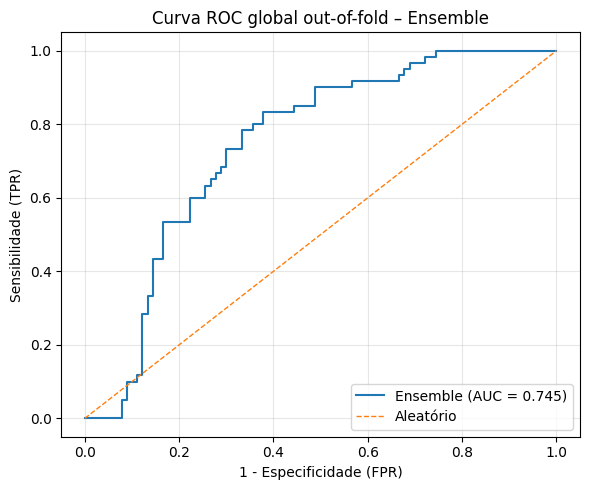

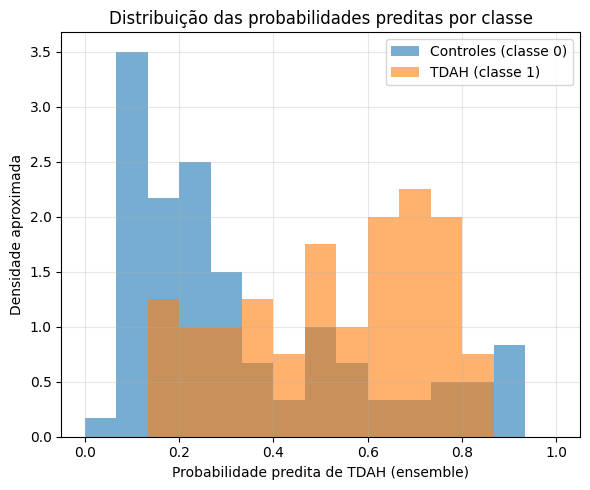

In [1]:
# ============================
# Main Thesis Script – Connectomes (AAL/SCH):
# Complex Networks Metrics +
# Class-specific templates + AUC/ACC +
# Atlas gating + Template Margins +
# Top-M edges + Simple Ensemble +
# Final Reproducible Version
# ============================

import warnings, math, os, json, random
warnings.filterwarnings("ignore")

from pathlib import Path
import numpy as np
import pandas as pd
import networkx as nx
from functools import partial

from sklearn.model_selection import StratifiedKFold, RepeatedStratifiedKFold
from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score, accuracy_score, roc_curve
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectKBest, mutual_info_classif

from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV

from xgboost import XGBClassifier

# ---------- QUICK CONFIG ----------
RANDOM_STATE = 29                      # reproducible
FAST_MODE = True
DISABLE_BETWEENNESS = True
FISHER_Z_TEMPLATES = True
N_REPEATS = 5                          # 5x5 = 25 folds
THR_LIST  = [0.20]                     # 1 sparsification threshold (stable & fast)
K_GRID    = [30, 45, 60]               # number of features after MI selection
M_TOP_EDGES = 60                       # number of Top-|Δ| edges between templates
TOP_EDGE_MODE = "raw"                # "raw" (edge value) or "diff_to_mid"
XGB_TREE_N_ESTIMATORS = 300            # stable stumps

# ---------- GLOBAL SEEDS (for reproducibility) ----------
os.environ["PYTHONHASHSEED"] = str(RANDOM_STATE)
np.random.seed(RANDOM_STATE)
random.seed(RANDOM_STATE)

# ---------- paths ----------
BASE = Path("/content/drive/MyDrive/RHARA_TCC/features").resolve()
COMB_CSV = BASE / "combined_connectomes.csv"
FD_CSV   = BASE / "fd_summary.csv"
LABELS_CSV = Path("/content/drive/MyDrive/RHARA_TCC/features/labels.csv")
RESULTS_DIR = Path("/content/drive/MyDrive/RHARA_TCC/results")
RESULTS_DIR.mkdir(parents=True, exist_ok=True)

# ---------- utils ----------
def vec_to_mat(vec: np.ndarray) -> np.ndarray:
    L = len(vec)
    n = int((1 + math.sqrt(1 + 8*L)) / 2)
    if n*(n-1)//2 != L:
        raise ValueError(f"Invalid length ({L}) for symmetric matrix definition.")
    M = np.zeros((n, n), dtype=np.float32)
    iu = np.triu_indices(n, k=1)
    M[iu] = vec
    M[(iu[1], iu[0])] = vec
    np.fill_diagonal(M, 0.0)
    return M

def proportional_threshold(W: np.ndarray, keep_prop=0.2) -> np.ndarray:
    A = W.copy()
    if keep_prop <= 0 or keep_prop >= 1:
        return A
    X = np.abs(A[np.triu_indices_from(A, 1)])
    if X.size == 0:
        return A
    k = max(1, int(np.floor(keep_prop * X.size)))
    thr = np.partition(X, -k)[-k]
    A[np.abs(A) < thr] = 0.0
    return A

def graph_metrics_from_matrix(W: np.ndarray, keep_prop=0.2) -> dict:
    Wt = proportional_threshold(W, keep_prop=keep_prop)
    Wabs = np.abs(Wt)
    n = Wabs.shape[0]
    G = nx.from_numpy_array(Wabs)

    m = {}
    m["n_nodes"] = n
    m["n_edges"] = G.number_of_edges()
    m["density"] = nx.density(G)

    strength = np.array([d for _, d in G.degree(weight="weight")], dtype=np.float32)
    if strength.size:
        m["strength_mean"] = float(np.mean(strength))
        m["strength_std"]  = float(np.std(strength))
        m["strength_max"]  = float(np.max(strength))
    else:
        m["strength_mean"] = m["strength_std"] = m["strength_max"] = 0.0

    clus = nx.clustering(G, weight="weight")
    clus_vals = np.array(list(clus.values()), dtype=np.float32) if clus else np.array([], dtype=np.float32)
    if clus_vals.size:
        m["clust_mean"] = float(np.mean(clus_vals))
        m["clust_std"]  = float(np.std(clus_vals))
    else:
        m["clust_mean"] = m["clust_std"] = 0.0

    try:
        m["transitivity"] = nx.transitivity(G)
    except:
        m["transitivity"] = 0.0
    try:
        m["assortativity"] = nx.degree_assortativity_coefficient(G)
    except:
        m["assortativity"] = 0.0
    try:
        m["global_efficiency"] = nx.global_efficiency(G)
    except:
        m["global_efficiency"] = 0.0

    if DISABLE_BETWEENNESS:
        m["betweenness_mean"] = 0.0
        m["betweenness_std"]  = 0.0
    else:
        try:
            btw = nx.betweenness_centrality(
                G, k=16, weight="weight",
                seed=RANDOM_STATE, normalized=True
            )
            btw_vals = np.array(list(btw.values()), dtype=np.float32)
            m["betweenness_mean"] = float(np.mean(btw_vals)) if btw_vals.size else 0.0
            m["betweenness_std"]  = float(np.std(btw_vals))  if btw_vals.size else 0.0
        except:
            m["betweenness_mean"] = 0.0
            m["betweenness_std"]  = 0.0
    return m

def fisher_z(x, eps=1e-7):
    x = np.clip(x, -1+eps, 1-eps)
    return np.arctanh(x)

def fisher_inv(z):
    return np.tanh(z)

def youden_threshold(y_true, y_score):
    y_true = np.asarray(y_true).astype(int)
    y_score = np.asarray(y_score, dtype=float)
    if y_score.size == 0 or np.unique(y_score).size < 2:
        return 0.5
    fpr, tpr, thr = roc_curve(y_true, y_score)
    j = tpr - fpr
    if j.size == 0:
        return 0.5
    j_best = int(np.argmax(j))
    return float(np.clip(thr[j_best], 0.0, 1.0))

def upper_vec(M: np.ndarray):
    iu = np.triu_indices_from(M, 1)
    return M[iu].astype(np.float32).ravel(), iu

def cos_dist(a, b, eps=1e-12):
    denom = (np.linalg.norm(a)*np.linalg.norm(b)) + eps
    sim = float(np.dot(a, b)/denom) if denom > 0 else 0.0
    return 1.0 - sim, sim

def corr_from_upper(a, b):
    if a.size == 0 or b.size == 0:
        return 0.0
    if np.std(a) < 1e-12 or np.std(b) < 1e-12:
        return 0.0
    return float(np.corrcoef(a, b)[0, 1])

def edgevecs_to_mats(X_edge: np.ndarray) -> np.ndarray:
    mats = [vec_to_mat(row.astype(np.float32)) for row in X_edge]
    return np.asarray(mats, dtype=np.float32)

print("[load] ", COMB_CSV)
df = pd.read_csv(COMB_CSV)
if "subject_id" not in df.columns:
    raise RuntimeError("combined_connectomes.csv must has 'subject_id' as a column.")

aal_cols = [c for c in df.columns if c.startswith("aal_edge_")]
sch_cols = [c for c in df.columns if c.startswith("sch_edge_")]
print(f"AAL edges: {len(aal_cols)} | SCH edges: {len(sch_cols)}")

if not LABELS_CSV.exists():
    raise RuntimeError("labels.csv not found.")
labels = pd.read_csv(LABELS_CSV)

# alvo
target_col = None
for c in ["target", "diagnosis", "DX", "dx"]:
    if c in labels.columns:
        target_col = c
        break
if target_col is None:
    raise RuntimeError("labels.csv must have 'diagnosis' or 'target' (or DX/dx).")

labels["sid_norm"] = labels["subject_id"].astype(str).str.replace(r"^X_","", regex=True)
s = labels[target_col]
s_num = pd.to_numeric(s, errors="coerce")
if s_num.notna().sum() < max(1, int(0.2 * len(s))):
    su = s.astype(str).str.strip().str.upper()
    map_str = {"ADHD":1, "TDC":0, "CONTROL":0, "HC":0, "CONTROLE":0,
               "PENDING":np.nan, "NA":np.nan, "N/A":np.nan, "NONE":np.nan, "":np.nan}
    s_num = pd.to_numeric(su.map(map_str), errors="coerce")
y_bin = s_num.map(lambda v: 0 if v == 0 else 1)
labels = labels.assign(target=y_bin).dropna(subset=["target"])
labels["target"] = labels["target"].astype(int)

print("[labels] n_total:", len(s), "| n_valid:", len(labels),
      "| single targets:", sorted(labels["target"].unique().tolist()))

df["sid_norm"] = df["subject_id"].astype(str).str.replace(r"^X_","", regex=True)
data = df.merge(labels[["sid_norm","target"]], on="sid_norm", how="inner")

# original arrays (float32) — confound treatment per fold
X_aal_edges_all = data[aal_cols].fillna(0.0).values.astype(np.float32) if aal_cols else None
X_sch_edges_all = data[sch_cols].fillna(0.0).values.astype(np.float32) if sch_cols else None
y_all = data["target"].values.astype(int)
fd_all = None
if Path(FD_CSV).exists():
    fd = pd.read_csv(FD_CSV)[["subject_id","fd_mean_raw"]]
    data = data.merge(fd, on="subject_id", how="left")
    if data["fd_mean_raw"].notna().any():
        fd_all = data["fd_mean_raw"].fillna(0.0).values.astype(np.float32)

print(f"[dataset] n={len(y_all)} (labels 0/1)")

# Check class balance
unique, counts = np.unique(y_all, return_counts=True)
class_counts = dict(zip(unique, counts))
print("[classes] target distro:", class_counts)

total = len(y_all)
for cls, cnt in class_counts.items():
    print(f"  classe {cls}: {cnt} sujeitos ({cnt/total:.1%})")

# ---------- feature helpers ----------
def metrics_to_vector(mdict, prefix=""):
    keys = ["n_nodes","n_edges","density","strength_mean","strength_std","strength_max",
            "clust_mean","clust_std","transitivity","assortativity","global_efficiency",
            "betweenness_mean","betweenness_std"]
    out, names = [], []
    for k in keys:
        out.append(float(mdict.get(k, 0.0)))
        names.append(f"{prefix}{k}")
    return np.array(out, dtype=np.float32), names

def build_template(mats: np.ndarray) -> np.ndarray:
    if mats is None or len(mats) == 0:
        return None
    iu = np.triu_indices_from(mats[0], 1)
    if FISHER_Z_TEMPLATES:
        Zs = []
        for M in mats:
            v = M[iu]
            Zs.append(fisher_z(np.clip(v, -0.999999, 0.999999)))
        Zmean = np.mean(np.vstack(Zs), axis=0)
        Mout = np.zeros_like(mats[0], dtype=np.float32)
        Mout[iu] = fisher_inv(Zmean).astype(np.float32)
        Mout[(iu[1], iu[0])] = Mout[iu]
        np.fill_diagonal(Mout, 0.0)
        return Mout
    else:
        return np.nanmean(mats, axis=0).astype(np.float32)

def subject_feature_block(M_subj, tpl_ctrl, tpl_adhd, atlas_prefix,
                          thr_list, tpl_metrics_cache_atlas):
    feats, names = [], []

    # (A) metrics (subject + deltas to templates) per threshold
    for prop in thr_list:
        ms = graph_metrics_from_matrix(M_subj, keep_prop=prop)
        v_ms, n_ms = metrics_to_vector(ms, prefix=f"{atlas_prefix}subj_t{int(prop*100)}_")
        feats.append(v_ms); names += n_ms

        v_mc, _ = tpl_metrics_cache_atlas["ctrl"][prop]
        v_ma, _ = tpl_metrics_cache_atlas["adhd"][prop]

        if v_mc is None or v_mc.size == 0:
            v_mc = np.zeros_like(v_ms, dtype=np.float32)
        if v_ma is None or v_ma.size == 0:
            v_ma = np.zeros_like(v_ms, dtype=np.float32)

        feats.append(v_mc); names += [f"{atlas_prefix}tplC_t{int(prop*100)}_{k.split('_',1)[1]}" for k in n_ms]
        feats.append(np.abs(v_ms - v_mc)); names += [f"{atlas_prefix}d_subj_tplC_t{int(prop*100)}_{k.split('_',1)[1]}" for k in n_ms]

        feats.append(v_ma); names += [f"{atlas_prefix}tplA_t{int(prop*100)}_{k.split('_',1)[1]}" for k in n_ms]
        feats.append(np.abs(v_ms - v_ma)); names += [f"{atlas_prefix}d_subj_tplA_t{int(prop*100)}_{k.split('_',1)[1]}" for k in n_ms]

    # (B) margins (difference of similarities)
    up_s, iu = upper_vec(M_subj)
    if tpl_ctrl is not None:
        up_c, _ = upper_vec(tpl_ctrl)
        frob_c = float(np.linalg.norm(up_s - up_c))
        cosd_c, cos_c = cos_dist(up_s, up_c)
        corr_c = corr_from_upper(up_s, up_c)
    else:
        frob_c, cosd_c, cos_c, corr_c = 0.0, 0.0, 0.0, 0.0

    if tpl_adhd is not None:
        up_a, _ = upper_vec(tpl_adhd)
        frob_a = float(np.linalg.norm(up_s - up_a))
        cosd_a, cos_a = cos_dist(up_s, up_a)
        corr_a = corr_from_upper(up_s, up_a)
    else:
        frob_a, cosd_a, cos_a, corr_a = 0.0, 0.0, 0.0, 0.0

    feats += [np.array([cos_a - cos_c, corr_a - corr_c, frob_c - frob_a], dtype=np.float32)]
    names += [f"{atlas_prefix}margin_cos", f"{atlas_prefix}margin_corr", f"{atlas_prefix}margin_frob"]

    return np.concatenate(feats).astype(np.float32), names, up_s, iu

def only_margins(X: np.ndarray, names: list):
    cols = [j for j, nm in enumerate(names)
            if nm.endswith("margin_cos") or nm.endswith("margin_corr") or nm.endswith("margin_frob")]
    if not cols:
        return X[:, :0], []
    return X[:, cols].astype(np.float32), [names[j] for j in cols]

mi_score = partial(mutual_info_classif, random_state=RANDOM_STATE, n_neighbors=3)

# ---------- build per-fold features with atlas gating ----------
def build_fold_features(tr_idx, te_idx, y, AAL_mats, SCH_mats,
                        thr_list=THR_LIST, m_top=M_TOP_EDGES):
    y_tr = y[tr_idx]
    idx_ctrl = tr_idx[y_tr == 0]
    idx_adhd = tr_idx[y_tr == 1]

    # templates by atlas
    tpl = {}
    if AAL_mats is not None and len(idx_ctrl)>0 and len(idx_adhd)>0:
        tpl["aal_ctrl"] = build_template(AAL_mats[idx_ctrl])
        tpl["aal_adhd"] = build_template(AAL_mats[idx_adhd])
    else:
        tpl["aal_ctrl"] = tpl["aal_adhd"] = None
    if SCH_mats is not None and len(idx_ctrl)>0 and len(idx_adhd)>0:
        tpl["sch_ctrl"] = build_template(SCH_mats[idx_ctrl])
        tpl["sch_adhd"] = build_template(SCH_mats[idx_adhd])
    else:
        tpl["sch_ctrl"] = tpl["sch_adhd"] = None

    # precompute template metrics per threshold
    tpl_metrics = {"aal": {"ctrl":{}, "adhd":{}}, "sch": {"ctrl":{}, "adhd":{}}}
    for atlas in ("aal","sch"):
        for cls in ("ctrl","adhd"):
            Mtpl = tpl.get(f"{atlas}_{cls}")
            if Mtpl is None:
                for prop in thr_list:
                    tpl_metrics[atlas][cls][prop] = (np.zeros(12, dtype=np.float32), [])
                continue
            for prop in thr_list:
                mt = graph_metrics_from_matrix(Mtpl, keep_prop=prop)
                v_mt, n_mt = metrics_to_vector(mt, prefix=f"{atlas}_tpl{cls[0].upper()}_t{int(prop*100)}_")
                tpl_metrics[atlas][cls][prop] = (v_mt, n_mt)

    # indexes of Top-M most different edges (per atlas)
    top_idx = {}
    def top_edges_for(atlas_key):
        Mc = tpl.get(f"{atlas_key}_ctrl"); Ma = tpl.get(f"{atlas_key}_adhd")
        if Mc is None or Ma is None: return None
        up_c, iu = upper_vec(Mc); up_a, _ = upper_vec(Ma)
        delta = np.abs(up_a - up_c)
        m = int(min(m_top, delta.size))
        if m <= 0: return None
        idx = np.argpartition(delta, -m)[-m:]
        return (idx, iu)

    if AAL_mats is not None: top_idx["aal"] = top_edges_for("aal")
    if SCH_mats is not None: top_idx["sch"] = top_edges_for("sch")

    def rows_for_indices(idxs, return_names=False, which="both"):
        rows, names_ref = [], None
        for i in idxs:
            parts, names_all = [], []
            # AAL
            if (which in ("aal","both")) and (AAL_mats is not None):
                feat, nms, up_s, iu = subject_feature_block(
                    AAL_mats[i], tpl["aal_ctrl"], tpl["aal_adhd"], "aal_", thr_list,
                    tpl_metrics_cache_atlas=tpl_metrics["aal"]
                )
                parts.append(feat); names_all += nms
                if top_idx.get("aal") is not None:
                    idx_top, iu_aal = top_idx["aal"]
                    vals = up_s[idx_top].astype(np.float32)
                    if TOP_EDGE_MODE == "diff_to_mid" and tpl["aal_ctrl"] is not None and tpl["aal_adhd"] is not None:
                        mid = 0.5*(tpl["aal_ctrl"][iu_aal][idx_top] + tpl["aal_adhd"][iu_aal][idx_top])
                        vals = (vals - mid).astype(np.float32)
                    parts.append(vals)
                    names_all += [f"aal_topedge_{k}" for k in range(len(idx_top))]
            # SCH
            if (which in ("sch","both")) and (SCH_mats is not None):
                feat, nms, up_s, iu = subject_feature_block(
                    SCH_mats[i], tpl["sch_ctrl"], tpl["sch_adhd"], "sch_", thr_list,
                    tpl_metrics_cache_atlas=tpl_metrics["sch"]
                )
                parts.append(feat); names_all += nms
                if top_idx.get("sch") is not None:
                    idx_top, iu_sch = top_idx["sch"]
                    vals = up_s[idx_top].astype(np.float32)
                    if TOP_EDGE_MODE == "diff_to_mid" and tpl["sch_ctrl"] is not None and tpl["sch_adhd"] is not None:
                        mid = 0.5*(tpl["sch_ctrl"][iu_sch][idx_top] + tpl["sch_adhd"][iu_sch][idx_top])
                        vals = (vals - mid).astype(np.float32)
                    parts.append(vals)
                    names_all += [f"sch_topedge_{k}" for k in range(len(idx_top))]

            x = np.concatenate(parts).astype(np.float32) if parts else np.zeros(1, dtype=np.float32)
            rows.append(x)
            if names_ref is None:
                names_ref = names_all[:]
        X = np.vstack(rows).astype(np.float32)
        X = np.nan_to_num(X, nan=0.0, posinf=0.0, neginf=0.0).astype(np.float32)
        return (X, names_ref) if return_names else X

    # 3 spaces: AAL, SCH or BOTH
    Xtr_aal, nm_aal   = rows_for_indices(tr_idx, True, "aal")
    Xte_aal           = rows_for_indices(te_idx, False, "aal")
    Xtr_sch, nm_sch   = rows_for_indices(tr_idx, True, "sch")
    Xte_sch           = rows_for_indices(te_idx, False, "sch")
    Xtr_both, nm_both = rows_for_indices(tr_idx, True, "both")
    Xte_both          = rows_for_indices(te_idx, False, "both")

    # versions with only MARGINS
    Xtr_aal_tm, _  = only_margins(Xtr_aal, nm_aal);  Xte_aal_tm, _  = only_margins(Xte_aal, nm_aal)
    Xtr_sch_tm, _  = only_margins(Xtr_sch, nm_sch);  Xte_sch_tm, _  = only_margins(Xte_sch, nm_sch)
    Xtr_both_tm, _ = only_margins(Xtr_both, nm_both);Xte_both_tm, _ = only_margins(Xte_both, nm_both)

    ytr = y[tr_idx].astype(int); yte = y[te_idx].astype(int)
    return (
        (Xtr_aal,  Xte_aal,  nm_aal),
        (Xtr_sch,  Xte_sch,  nm_sch),
        (Xtr_both, Xte_both, nm_both),
        (Xtr_aal_tm,  Xte_aal_tm),
        (Xtr_sch_tm,  Xte_sch_tm),
        (Xtr_both_tm, Xte_both_tm),
        ytr, yte
    )

# ---------- Evaluation with atlas gating + ensemble ----------
outer = RepeatedStratifiedKFold(
    n_splits=5, n_repeats=N_REPEATS, random_state=RANDOM_STATE
)

results = {
    "Logistic (Ridge)":  {"auc":[], "acc":[]},
    "XGBoost (stumps)":  {"auc":[], "acc":[]},
    "TemplateMargin":    {"auc":[], "acc":[]},
    "Ensemble (avg)":    {"auc":[], "acc":[]},
}
oof_ens_scores, oof_ens_labels = [], []

# confound regression by fold
def regress_out_confound_split(X, confound, tr_idx, te_idx):
    if X is None: return None
    if confound is None: return X
    c_tr = np.c_[
        np.ones_like(confound[tr_idx], dtype=np.float32),
        confound[tr_idx].reshape(-1,1).astype(np.float32)
    ]
    beta = np.linalg.pinv(c_tr) @ X[tr_idx]
    c_all = np.c_[
        np.ones_like(confound, dtype=np.float32),
        confound.reshape(-1,1).astype(np.float32)
    ]
    X_hat_all = c_all @ beta
    X_resid = X.copy().astype(np.float32)
    X_resid[tr_idx] = (X[tr_idx] - X_hat_all[tr_idx]).astype(np.float32)
    X_resid[te_idx] = (X[te_idx] - X_hat_all[te_idx]).astype(np.float32)
    return X_resid

def pick_space(XA, XS, XB, ytr, model_name, spw=None):
    """Choose AAL vs SCH vs BOTH by AUC (inner CV). model_name ∈ {'ridge','xgb','tm'}."""
    spaces = {"aal": XA, "sch": XS, "both": XB}
    if model_name == "ridge":
        pipe = Pipeline([
            ("scaler", RobustScaler()),
            ("sel", SelectKBest(score_func=mi_score, k=K_GRID[0])),
            ("clf", LogisticRegression(
                penalty="l2", solver="lbfgs",
                class_weight="balanced", max_iter=6000, n_jobs=1
            ))
        ])
        grid = {"sel__k": K_GRID, "clf__C": [0.3, 1.0, 3.0]}
    elif model_name == "xgb":
        assert spw is not None
        pipe = Pipeline([
            ("sel", SelectKBest(score_func=mi_score, k=K_GRID[0])),
            ("clf", XGBClassifier(
                booster="gbtree", max_depth=1,
                n_estimators=XGB_TREE_N_ESTIMATORS, learning_rate=0.06,
                subsample=0.9, colsample_bytree=0.6, min_child_weight=1,
                reg_lambda=1.0, reg_alpha=0.0, objective="binary:logistic",
                eval_metric="auc", random_state=RANDOM_STATE,
                n_jobs=1,  # determinístico
                scale_pos_weight=spw
            ))
        ])
        grid = {"sel__k": K_GRID}
    else:  # "tm"
        pipe = Pipeline([
            ("scaler", RobustScaler()),
            ("clf", LogisticRegression(
                penalty="l2", solver="lbfgs",
                class_weight="balanced", max_iter=6000, n_jobs=1
            ))
        ])
        grid = {"clf__C": [0.3, 1.0, 3.0]}

    inner = StratifiedKFold(n_splits=3, shuffle=True, random_state=RANDOM_STATE)

    best_auc, best_key, best_fit = -np.inf, None, None
    for key, Xspace in spaces.items():
        if Xspace is None or Xspace.shape[1] == 0:
            continue
        gs = HalvingGridSearchCV(
            pipe, param_grid=grid, scoring="roc_auc",
            cv=inner, n_jobs=1, factor=3, verbose=0  # n_jobs=1 for reproducibility
        )
        gs.fit(Xspace, ytr)
        if gs.best_score_ > best_auc:
            best_auc, best_key, best_fit = gs.best_score_, key, gs.best_estimator_
    if best_key is None:
        best_key, best_fit = "both", pipe
        best_fit.fit(XB, ytr)
    return best_key, best_fit

for fold_id, (tr_idx, te_idx) in enumerate(outer.split(y_all, y_all), 1):

    # FD por dobra
    if fd_all is not None:
        X_aal_edges = regress_out_confound_split(
            X_aal_edges_all, fd_all, tr_idx, te_idx
        ) if X_aal_edges_all is not None else None
        X_sch_edges = regress_out_confound_split(
            X_sch_edges_all, fd_all, tr_idx, te_idx
        ) if X_sch_edges_all is not None else None
    else:
        X_aal_edges = X_aal_edges_all
        X_sch_edges = X_sch_edges_all

    # It builds residual mats for all fold subjects
    AAL_mats_all = edgevecs_to_mats(X_aal_edges) if X_aal_edges is not None else None
    SCH_mats_all = edgevecs_to_mats(X_sch_edges) if X_sch_edges is not None else None

    (
        (Xtr_aal,  Xte_aal,  nm_aal),
        (Xtr_sch,  Xte_sch,  nm_sch),
        (Xtr_both, Xte_both, nm_both),
        (Xtr_aal_tm,  Xte_aal_tm),
        (Xtr_sch_tm,  Xte_sch_tm),
        (Xtr_both_tm, Xte_both_tm),
        ytr, yte
    ) = build_fold_features(
        tr_idx, te_idx, y_all, AAL_mats_all, SCH_mats_all, THR_LIST, M_TOP_EDGES
    )

    # 1) Logistic (Ridge)
    sp_ridge_key, best_ridge = pick_space(Xtr_aal, Xtr_sch, Xtr_both, ytr, "ridge")
    Xtr_r = {"aal": Xtr_aal, "sch": Xtr_sch, "both": Xtr_both}[sp_ridge_key]
    Xte_r = {"aal": Xte_aal, "sch": Xte_sch, "both": Xte_both}[sp_ridge_key]
    if hasattr(best_ridge.named_steps["clf"], "predict_proba"):
        ypr_tr_r = best_ridge.predict_proba(Xtr_r)[:, 1]
        ypr_te_r = best_ridge.predict_proba(Xte_r)[:, 1]
    else:
        s_tr_r = best_ridge.decision_function(Xtr_r); s_te_r = best_ridge.decision_function(Xte_r)
        smin, smax = s_tr_r.min(), s_tr_r.max()
        ypr_tr_r = (s_tr_r - smin) / (smax - smin + 1e-12)
        ypr_te_r = (s_te_r - smin) / (smax - smin + 1e-12)
    thr_r = youden_threshold(ytr, ypr_tr_r)
    results["Logistic (Ridge)"]["auc"].append(roc_auc_score(yte, ypr_te_r))
    results["Logistic (Ridge)"]["acc"].append(accuracy_score(yte, (ypr_te_r >= thr_r).astype(int)))

    # 2) XGBoost (stumps)
    spw = float((ytr==0).sum()/max(1,(ytr==1).sum()))
    sp_xgb_key, best_xgb = pick_space(Xtr_aal, Xtr_sch, Xtr_both, ytr, "xgb", spw=spw)
    Xtr_x = {"aal": Xtr_aal, "sch": Xtr_sch, "both": Xtr_both}[sp_xgb_key]
    Xte_x = {"aal": Xte_aal, "sch": Xte_sch, "both": Xte_both}[sp_xgb_key]
    ypr_tr_x = best_xgb.predict_proba(Xtr_x)[:, 1]
    ypr_te_x = best_xgb.predict_proba(Xte_x)[:, 1]
    thr_x = youden_threshold(ytr, ypr_tr_x)
    results["XGBoost (stumps)"]["auc"].append(roc_auc_score(yte, ypr_te_x))
    results["XGBoost (stumps)"]["acc"].append(accuracy_score(yte, (ypr_te_x >= thr_x).astype(int)))

    # 3) TemplateMargin
    sp_tm_key, best_tm = pick_space(Xtr_aal_tm, Xtr_sch_tm, Xtr_both_tm, ytr, "tm")
    Xtr_tm = {"aal": Xtr_aal_tm, "sch": Xtr_sch_tm, "both": Xtr_both_tm}[sp_tm_key]
    Xte_tm = {"aal": Xte_aal_tm, "sch": Xte_sch_tm, "both": Xte_both_tm}[sp_tm_key]

    if Xtr_tm is None or Xtr_tm.shape[1] == 0:
        Xtr_tm = Xtr_r; Xte_tm = Xte_r
        best_tm = Pipeline([
            ("scaler", RobustScaler()),
            ("clf", LogisticRegression(
                penalty="l2", solver="lbfgs",
                class_weight="balanced", max_iter=3000, n_jobs=1
            ))
        ])
        best_tm.fit(Xtr_tm, ytr)
    ypr_tr_tm = best_tm.predict_proba(Xtr_tm)[:,1]
    ypr_te_tm = best_tm.predict_proba(Xte_tm)[:,1]
    thr_tm = youden_threshold(ytr, ypr_tr_tm)
    results["TemplateMargin"]["auc"].append(roc_auc_score(yte, ypr_te_tm))
    results["TemplateMargin"]["acc"].append(accuracy_score(yte, (ypr_te_tm >= thr_tm).astype(int)))

    # Ensemble (simple probability average)
    ypr_ens = np.mean(np.vstack([ypr_te_tm, ypr_te_r, ypr_te_x]), axis=0)
    results["Ensemble (avg)"]["auc"].append(roc_auc_score(yte, ypr_ens))
    results["Ensemble (avg)"]["acc"].append(accuracy_score(yte, (ypr_ens >= 0.5).astype(int)))

    oof_ens_scores.append(ypr_ens.astype(np.float32))
    oof_ens_labels.append(yte.astype(int))

# ---------- Summary per model ----------
np.save("/content/drive/MyDrive/RHARA_TCC/results/r_acc_list_logreg_.npy", results["Logistic (Ridge)"]["acc"])
np.save("/content/drive/MyDrive/RHARA_TCC/results/r_acc_list_xgb_.npy",   results["XGBoost (stumps)"]["acc"])
np.save("/content/drive/MyDrive/RHARA_TCC/results/r_acc_list_tm_.npy",    results["TemplateMargin"]["acc"])
np.save("/content/drive/MyDrive/RHARA_TCC/results/r_acc_list_ens_.npy",   results["Ensemble (avg)"]["acc"])

np.save("/content/drive/MyDrive/RHARA_TCC/results/r_auc_list_logreg_.npy", results["Logistic (Ridge)"]["auc"])
np.save("/content/drive/MyDrive/RHARA_TCC/results/r_auc_list_xgb_.npy",   results["XGBoost (stumps)"]["auc"])
np.save("/content/drive/MyDrive/RHARA_TCC/results/r_auc_list_tm_.npy",    results["TemplateMargin"]["auc"])
np.save("/content/drive/MyDrive/RHARA_TCC/results/r_auc_list_ens_.npy",   results["Ensemble (avg)"]["auc"])

summary_rows = []
for name in results:
    auc = np.array(results[name]["auc"]); acc = np.array(results[name]["acc"])
    print(f"{name:17s} | AUC {auc.mean():.3f}±{auc.std():.3f} | ACC {acc.mean():.3f}±{acc.std():.3f} (n={len(acc)})")
    summary_rows.append({
        "model": name,
        "auc_mean": float(auc.mean()), "auc_std": float(auc.std()),
        "acc_mean": float(acc.mean()), "acc_std": float(acc.std()), "n": int(len(acc))
    })
pd.DataFrame(summary_rows).to_csv(RESULTS_DIR / "summary_metrics.csv", index=False)

# ---------- GLOBAL optimal threshold (Youden) for the ENSEMBLE ----------
if len(oof_ens_scores) > 0:
    y_scores_all = np.concatenate(oof_ens_scores, axis=0)
    y_true_all   = np.concatenate(oof_ens_labels, axis=0).astype(int)

    thr_global = youden_threshold(y_true_all, y_scores_all)

    acc_fixed = accuracy_score(y_true_all, (y_scores_all >= 0.5).astype(int))
    acc_glob  = accuracy_score(y_true_all, (y_scores_all >= thr_global).astype(int))
    auc_glob  = roc_auc_score(y_true_all, y_scores_all)

    print("\n[Ensemble - GLOBAL eval (out-of-fold, all external test predictions combined)]")
    print(f"AUC (oof)          : {auc_glob:.3f}")
    print(f"ACC @0.5           : {acc_fixed:.3f}")
    print(f"ACC @Youden_global : {acc_glob:.3f}  (thr* = {thr_global:.3f})")

    with open(RESULTS_DIR / "ensemble_threshold_global.json", "w") as f:
        json.dump({
            "auc_oof": float(auc_glob),
            "acc_at_0p5": float(acc_fixed),
            "acc_at_youden_global": float(acc_glob),
            "thr_global": float(thr_global)
        }, f, indent=2)

print(f"\n[OK] Recorded results at {RESULTS_DIR}")

import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

# ------------------------------------------------------------------
# 1) Reconstruct global out-of-fold vectors
# ------------------------------------------------------------------
y_scores_all = np.concatenate(oof_ens_scores, axis=0)
y_true_all   = np.concatenate(oof_ens_labels, axis=0).astype(int)

# AUC global
auc_global = roc_auc_score(y_true_all, y_scores_all)
print(f"AUC global (ensemble, oof) = {auc_global:.3f}")

# ------------------------------------------------------------------
# 2) Global ROC Curve
# ------------------------------------------------------------------
fpr, tpr, thresholds = roc_curve(y_true_all, y_scores_all)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f"Ensemble (AUC = {auc_global:.3f})")
plt.plot([0, 1], [0, 1], linestyle="--", linewidth=1, label="Aleatório")

plt.xlabel("1 - Specificity (FPR)")
plt.ylabel("Sensibility (TPR)")
plt.title("Global ROC Curve (OOF) – Ensemble")
plt.legend(loc="lower right")
plt.grid(alpha=0.3)

plt.tight_layout()
plt.savefig("/content/drive/MyDrive/RHARA_TCC/results/roc_ensemble_oof.png", dpi=300)
plt.show()

scores_ctrl = y_scores_all[y_true_all == 0]
scores_adhd = y_scores_all[y_true_all == 1]

plt.figure(figsize=(6, 5))
bins = np.linspace(0, 1, 16)

plt.hist(scores_ctrl, bins=bins, alpha=0.6, density=True,
         label="Controles (classe 0)")
plt.hist(scores_adhd, bins=bins, alpha=0.6, density=True,
         label="TDAH (classe 1)")

plt.xlabel("ADHD Predicted Probability by Ensemble")
plt.ylabel("Approximate density")
plt.title("Probability distribution per class")
plt.legend()
plt.grid(alpha=0.3)

plt.tight_layout()
plt.savefig("/content/drive/MyDrive/RHARA_TCC/results/hist_scores_ensemble.png", dpi=300)
plt.show()



=== COMBINED METRICS (0.7*AUC + 0.3*ACC) PER FOLD ===
     FOLD  LogReg_Ridge  XGB_Stumps     TMM  Ensemble
0       1        0.6167      0.6167  0.6667    0.6667
1       2        0.9500      0.9000  0.7944    1.0000
2       3        0.7250      0.6875  0.7750    0.7750
3       4        0.7750      0.6750  0.5875    0.7250
4       5        0.7250      0.6875  0.7250    0.7250
5       6        0.6167      0.3833  0.7444    0.5389
6       7        0.9500      0.9000  0.8722    0.9500
7       8        0.4500      0.5000  0.7250    0.5375
8       9        0.5500      0.5875  0.3625    0.5000
9      10        1.0000      0.9500  0.9500    1.0000
10     11        0.7944      0.7444  0.7944    0.7944
11     12        0.7944      0.8222  0.7167    0.7944
12     13        0.8125      0.5500  0.7250    0.6375
13     14        0.5875      0.7250  0.5500    0.7250
14     15        0.7750      0.8125  0.5875    0.7250
15     16        0.5667      0.6167  0.5667    0.6167
16     17        0.8222    

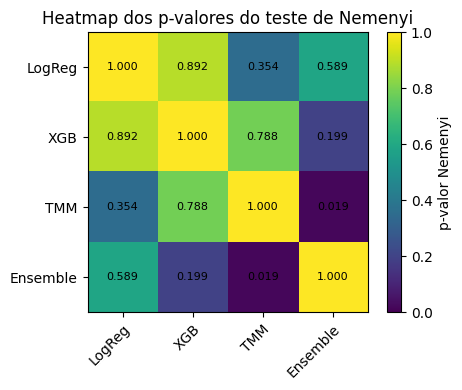

P-values Heatmap saved at /content/drive/MyDrive/RHARA_TCC/results/_nemenyi_heatmap_.png


In [ ]:
import numpy as np
import pandas as pd
from scipy.stats import friedmanchisquare
import scikit_posthocs as sp
import matplotlib.pyplot as plt

# ====== Retrieving AUC & ACC by model (already saved) ======
auc_ridge  = np.load("/content/drive/MyDrive/RHARA_TCC/results/r_auc_list_logreg_.npy")
auc_xgb    = np.load("/content/drive/MyDrive/RHARA_TCC/results/r_auc_list_xgb_.npy")
auc_tm     = np.load("/content/drive/MyDrive/RHARA_TCC/results/r_auc_list_tm_.npy")
auc_ens    = np.load("/content/drive/MyDrive/RHARA_TCC/results/r_auc_list_ens_.npy")

acc_ridge  = np.load("/content/drive/MyDrive/RHARA_TCC/results/r_acc_list_logreg_.npy")
acc_xgb    = np.load("/content/drive/MyDrive/RHARA_TCC/results/r_acc_list_xgb_.npy")
acc_tm     = np.load("/content/drive/MyDrive/RHARA_TCC/results/r_acc_list_tm_.npy")
acc_ens    = np.load("/content/drive/MyDrive/RHARA_TCC/results/r_acc_list_ens_.npy")

# ====== 1) Define combined metric for the test (70% AUC / 30% ACC) ======
M_ridge = 0.7*auc_ridge + 0.3*acc_ridge
M_xgb   = 0.7*auc_xgb   + 0.3*acc_xgb
M_tm    = 0.7*auc_tm    + 0.3*acc_tm
M_ens   = 0.7*auc_ens   + 0.3*acc_ens

# 25×4 matrix
data_M = np.vstack([M_ridge, M_xgb, M_tm, M_ens]).T

df_combined = pd.DataFrame({
    "Fold": np.arange(1, len(M_ridge) + 1),
    "LogReg_Ridge": M_ridge,
    "XGB_Stumps":   M_xgb,
    "TMM":          M_tm,
    "Ensemble":     M_ens
})

df_combined = df_combined.round(3)

print("\n=== COMBINED METRICS (0.7*AUC + 0.3*ACC) POR DOBRA ===")
print(df_combined)

# Saving CSV
table_csv = "/content/drive/MyDrive/RHARA_TCC/results/metricas_combinadas_por_dobra.csv"
df_combined.to_csv(table_csv, index=False)
print(f"\nP-values Nemenyi table saved at {table_csv}")

# ====== 2) Friedman Test ======
stat, p = friedmanchisquare(
    data_M[:,0], data_M[:,1], data_M[:,2], data_M[:,3]
)

print("\n=== TESTE DE FRIEDMAN (métrica composta AUC+ACC) ===")
print(f"χ²_F = {stat:.4f}")
print(f"p-valor = {p:.6f}")

if p < 0.05:
    print("→ There is significant difference between the models.")
else:
    print("→ There is not significant difference between the models.")

# ====== 3) Post-hoc Nemenyi ======
print("\n=== NEMENYI TEST (post-hoc) ===")
nemenyi = sp.posthoc_nemenyi_friedman(data_M)
nemenyi.index = ["LogReg","XGB","TMM","Ensemble"]
nemenyi.columns = ["LogReg","XGB","TMM","Ensemble"]
print(nemenyi)

# Saving table
out_csv = "/content/drive/MyDrive/RHARA_TCC/results/nemenyi_combined_metrics_.csv"
nemenyi.to_csv(out_csv)
print(f"P-values Nemenyi table saved at {out_csv}")

# ====== 4) Nemenyi Heatmap ======
fig, ax = plt.subplots(figsize=(5, 4))

# P-values matrix
im = ax.imshow(nemenyi.values, vmin=0.0, vmax=1.0)

# ticks e labels
ax.set_xticks(np.arange(nemenyi.shape[1]))
ax.set_yticks(np.arange(nemenyi.shape[0]))
ax.set_xticklabels(nemenyi.columns)
ax.set_yticklabels(nemenyi.index)

# 
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

# P-values
for i in range(nemenyi.shape[0]):
    for j in range(nemenyi.shape[1]):
        pval = nemenyi.iloc[i, j]
        ax.text(j, i, f"{pval:.3f}", ha="center", va="center", fontsize=8)

# color bar
cbar = fig.colorbar(im, ax=ax)
cbar.set_label("Nemenyi's p-value")

ax.set_title("P-values Heatmap of Nemenyi's Test")
fig.tight_layout()

# Saving figure
out_fig = "/content/drive/MyDrive/RHARA_TCC/results/nemenyi_heatmap_.png"
plt.savefig(out_fig, dpi=300)
plt.show()

print(f"P-values Heatmap saved at {out_fig}")


In [ ]:
import numpy as np
import pandas as pd
from pathlib import Path
from scipy.stats import t

# ===== PATH CONFIG =====
BASE_RESULTS = Path("/content/drive/MyDrive/RHARA_TCC/results").resolve()
SUMMARY_CSV  = BASE_RESULTS / "summary_metrics.csv"

print("[load] ", SUMMARY_CSV)
df = pd.read_csv(SUMMARY_CSV)

# Required columns: model, auc_mean, auc_std, acc_mean, acc_std, n
required_cols = ["model", "auc_mean", "auc_std", "acc_mean", "acc_std", "n"]
missing = [c for c in required_cols if c not in df.columns]
if missing:
    raise RuntimeError(f"summary_metrics.csv is invalid: {missing}")

rows_ci = []

print("\n=== Confidence Intervals of 95% (AUC e ACC) ===\n")

for _, row in df.iterrows():
    model = row["model"]
    n     = int(row["n"])

    # graus de liberdade
    dfree = n - 1
    if dfree <= 0:
        raise RuntimeError(f"n Invalid for CI of {model}: n={n}")

    # 95% (bilateral)
    t_crit = t.ppf(0.975, df=dfree)

    # ----- AUC -----
    auc_mean = float(row["auc_mean"])
    auc_std  = float(row["auc_std"])
    se_auc   = auc_std / np.sqrt(n)
    half_auc = t_crit * se_auc
    auc_low  = auc_mean - half_auc
    auc_high = auc_mean + half_auc

    # ----- ACC -----
    acc_mean = float(row["acc_mean"])
    acc_std  = float(row["acc_std"])
    se_acc   = acc_std / np.sqrt(n)
    half_acc = t_crit * se_acc
    acc_low  = acc_mean - half_acc
    acc_high = acc_mean + half_acc

    print(f"Model: {model}")
    print(f"AUC  média = {auc_mean:.3f}  (IC95%: {auc_low:.3f} ; {auc_high:.3f})")
    print(f"ACC  média = {acc_mean:.3f}  (IC95%: {acc_low:.3f} ; {acc_high:.3f})\n")

    rows_ci.append({
        "model": model,
        "n": n,
        "auc_mean": auc_mean,
        "auc_std": auc_std,
        "auc_ci95_low": auc_low,
        "auc_ci95_high": auc_high,
        "acc_mean": acc_mean,
        "acc_std": acc_std,
        "acc_ci95_low": acc_low,
        "acc_ci95_high": acc_high,
    })

# Saving CSV table and exporting it
ci_df = pd.DataFrame(rows_ci)
out_csv = BASE_RESULTS / "summary_metrics_with_ci95.csv"
ci_df.to_csv(out_csv, index=False)

print(f"CI table saved at {out_csv}")
